In [1]:
import numpy as np
import ast
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy
from itertools import product

In [ ]:
def generate_error():

    error_list = []
    with open('dataset/legitimate_channel_error.csv', newline='') as csvfile:
        
        for line in csvfile:
            error_list.append(ast.literal_eval(line.strip()))

    error_list_clean = [elem[0] if isinstance(elem, tuple) else elem for elem in error_list]

    return error_list_clean

In [3]:
def random_gen(n):
    if n <= 0:
        raise ValueError("n needs to be > 0")
    return random.randint(0, n - 1)

In [4]:
def xor(x,y): #probabilmente si potrebbe usare numpy
    result = []
    for i in range(len(x)):
        result.append(x[i] ^ y[i])
    return result

In [5]:
def uniform_wiretap_channel(input, legit_error = generate_error, eve_error = generate_error):

    legitimate_error_list = legit_error()
    eavesdropper_error_list = eve_error()
    legitimate_error = legitimate_error_list[random_gen(8)]
    eavesdropper_error = eavesdropper_error_list[random_gen(8)]

    return (xor(input,legitimate_error),xor(input,eavesdropper_error))


In [6]:
def run_wiretap_simulation(input, num_runs=10**4):
    results = {}

    for _ in range(num_runs):
        y, z = uniform_wiretap_channel(input)

        # Convertiamo le liste x e y in tuple per una gestione più facile nel dizionario
        y_tuple = tuple(y)
        z_tuple = tuple(z)

        if (y_tuple, z_tuple) not in results:
            results[(y_tuple, z_tuple)] = 0
        results[(y_tuple, z_tuple)] += 1

    # Calcoliamo le probabilità
    probabilities = {key: count / num_runs for key, count in results.items()}
    
    return probabilities

# Funzione per dividere le probabilità per x e y
def divide_probabilities(probabilities):
    y_probabilities = {}
    z_probabilities = {}

    # Dividiamo le probabilità
    for (y, z), prob in probabilities.items():
        if y not in y_probabilities:
            y_probabilities[y] = 0
        if z not in z_probabilities:
            z_probabilities[z] = 0
        
        y_probabilities[y] += prob
        z_probabilities[z] += prob

    # Ordinamento delle probabilità
    y_probabilities = dict(sorted(y_probabilities.items()))
    z_probabilities = dict(sorted(z_probabilities.items()))

    return y_probabilities, z_probabilities

In [7]:
probabilities = run_wiretap_simulation([1,0,0,1,0,0,0],num_runs=10**4)
y_probabilities, z_probabilities = divide_probabilities(probabilities)

In [8]:
def plot_pmd_given_symbol_bits(z_probabilities, x=[1, 0, 0, 1, 0, 0, 0]):
    #print("Tipo di z_probabilities:", type(z_probabilities))
    #print("Esempio contenuto:", list(z_probabilities.items())[:5])

    z_values = []
    probabilities = []

    for z_tuple, prob in z_probabilities.items():
        if isinstance(z_tuple, tuple) and isinstance(prob, (int, float)):
            # Converti la tupla binaria in intero
            z_int = int(''.join(map(str, z_tuple)), 2)
            z_values.append(z_int)
            probabilities.append(prob)
        else:
            print("⚠️ Salto coppia non valida:", z_tuple, prob)

    z_values = np.array(z_values)
    probabilities = np.array(probabilities)

    # Ordina i dati per z intero
    sorted_indices = np.argsort(z_values)
    z_values = z_values[sorted_indices]
    probabilities = probabilities[sorted_indices]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(z_values, probabilities, color='skyblue')
    plt.xlabel("z (valore intero della sequenza binaria)")
    plt.ylabel("PMD")
    plt.title(f'PMD di $Z$ dato {x}')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Somma delle probabilità in alto a sinistra
    plt.text(0.01, max(probabilities), f"Somma P = {np.sum(probabilities):.4f}", 
             fontsize=12, verticalalignment='top', horizontalalignment='left')

    plt.tight_layout()
    plt.show()

x = [1, 0, 0, 1, 0, 0, 0]

In [9]:
def analyze_error_distribution():
    error_list = generate_error()
    weights = [sum(e) for e in error_list]
    
    from collections import Counter
    distribution = Counter(weights)
    
    print("Distribuzione del peso (numero di bit a 1) nei vettori di errore:")
    for weight, count in sorted(distribution.items()):
        print(f"{weight} bit a 1: {count} occorrenze")

In [10]:
analyze_error_distribution()


Distribuzione del peso (numero di bit a 1) nei vettori di errore:
0 bit a 1: 1 occorrenze
1 bit a 1: 7 occorrenze


## Task 2

In [11]:
H = np.array([
    [1, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 0, 1]
])


def error_correction(y,s):
    H = np.array([
        [1, 0, 0, 0, 1, 1, 1],
        [0, 1, 0, 1, 0, 1, 1],
        [0, 0, 1, 1, 1, 0, 1]
    ])

    e_hat = np.zeros_like(y)
    for i in range(7):
        e_i = H[:, i] % 2
        if np.array_equal(s, e_i):
            e_hat[i] = 1
    return xor(y, e_hat)

    

def information_reconciliation(y, c):
    y = np.array(y)
    
    s = np.dot(H, y) % 2
    s = xor(c, s)

    x_hat = error_correction(y, s)

    return x_hat


def simulate_forward_information_reconciliation(channel, legit_error, eve_error, n_runtimes=10**2):

    success_Bob = 0
    success_Eve = 0

    for _ in range (n_runtimes):

        x = [random.randint(0,1) for i in range (7)]


        y, z = channel(x, legit_error, eve_error)

        s_A = np.dot(H, x) % 2

        x_hat_Bob = information_reconciliation(y, s_A)
        x_hat_Eve = information_reconciliation(z, s_A)

        y = np.array(y)
        z = np.array(z)
        #print(y)
        #print(x,"\n")

        if np.array_equal(x, x_hat_Bob):
            success_Bob += 1
        if np.array_equal(x, x_hat_Eve):
            success_Eve += 1  


    return success_Bob/n_runtimes, success_Eve/n_runtimes  



In [40]:
success_Bob, success_Eve = simulate_forward_information_reconciliation(channel=uniform_wiretap_channel,
                                                                    legit_error=generate_error,
                                                                    eve_error=generate_error)

print(f"Success probability of information reconciliation for Bob: {success_Bob}")
print(f"Success probability of information reconciliation for Eve: {success_Eve}")


Success probability of information reconciliation for Bob: 1.0
Success probability of information reconciliation for Eve: 1.0


## Task 3

In [42]:
def simulate_reverse_information_reconciliation(channel, legit_error, eaves_error, n_runtimes=10**2):

    success_Alice = 0
    success_Eve = 0

    for _ in range (n_runtimes):

        x = [random.randint(0,1) for i in range (7)]


        y, z = channel(x, legit_error, eaves_error)

        c = np.dot(H, y) % 2 

        y_hat_Alice = information_reconciliation(x, c)
        y_hat_Eve = information_reconciliation(z, c)
        

        if np.array_equal(y, y_hat_Alice):
            success_Alice += 1
        if np.array_equal(y, y_hat_Eve):
            success_Eve += 1   
    return success_Alice/n_runtimes, success_Eve/n_runtimes  


In [43]:
success_Alice, success_Eve = simulate_reverse_information_reconciliation(channel=uniform_wiretap_channel,
                                                                    legit_error=generate_error,
                                                                    eaves_error=generate_error)

print(f"Success probability of information reconciliation for Alice: {success_Alice}")
print(f"Success probability of information reconciliation for Eve: {success_Eve}")


Success probability of information reconciliation for Alice: 1.0
Success probability of information reconciliation for Eve: 0.38


## Task 4

In [80]:
A = np.array([
        [1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 1, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 0]
    ])

def det_privacy_amplification(x, A):
    return np.dot(A, x) % 2


def prob_privacy_amplification(x, l):
    assert len(x) == 4
    assert l > 0 and l < 4

    int_x = int("".join(str(elem) for elem in x), 2)
    p = 17
    a = 7
    b = 3
    res = ((a * int_x + b) % p) % (2 ** l)
    res = np.array(list(np.binary_repr(res, width=l))).astype(int)
    return res

def privacy_amplification(x, l, A= A):
    x_prime = det_privacy_amplification(x, A)
    k = prob_privacy_amplification(x_prime, l)
    return k

In [16]:
def eval_det_privacy_amplification(iterations = 10**4, A = A):
    conj_prob = {}
    syndrome_prob = {}
    y_prime_prob = {}
    for _ in range(iterations):
        y = np.random.randint(0, 2, size=(7))
        c = np.dot(H, y) % 2
        y_prime = det_privacy_amplification(y, A = A)
        dict_key = (tuple(y_prime), tuple(c)) 
        if dict_key not in conj_prob:
            conj_prob[dict_key] = 0
        conj_prob[dict_key] += 1
        if tuple(c) not in syndrome_prob:
            syndrome_prob[tuple(c)] = 0
        syndrome_prob[tuple(c)] += 1
        if tuple(y_prime) not in y_prime_prob:
            y_prime_prob[tuple(y_prime)] = 0
        y_prime_prob[tuple(y_prime)] += 1
    
    conj_prob = {key: count / iterations for key, count in conj_prob.items()}
    conj_prob = dict(sorted(conj_prob.items()))
    
    syndrome_prob = {key: count / iterations for key, count in syndrome_prob.items()}
    syndrome_prob = dict(sorted(syndrome_prob.items()))
    
    y_prime_prob = {key: count / iterations for key, count in y_prime_prob.items()}
    y_prime_prob = dict(sorted(y_prime_prob.items()))
    
    # Verifica dell'indipendenza
    for (y_prime, c), prob in conj_prob.items():
        if y_prime in y_prime_prob and c in syndrome_prob:
            expected_prob = y_prime_prob[y_prime] * syndrome_prob[c]
            if not np.isclose(prob, expected_prob, atol=1e-3):
                print(f"Indipendenza violata per {np.array(y_prime)}, {np.array(c)}: P({np.array(y_prime)}, {np.array(c)}) = {prob}, atteso = {expected_prob}")
    else:
        print("Indipendenza verificata per tutte le coppie.")
    
    
    return conj_prob, syndrome_prob, y_prime_prob

In [17]:
conj_prob, syndrome_prob, y_prime_prob = eval_det_privacy_amplification(iterations=10**6)
print("Probabilità congiunta:")
for key, value in conj_prob.items():
    print(f"Probabilità di {np.array(key[0])} e {np.array(key[1])}: {value}")
print("Probabilità marginale del sindrome:")
for key, value in syndrome_prob.items():
    print(f"Probabilità di {np.array(key)}: {value}")
print("Probabilità marginale del vettore di errore:")
for key, value in y_prime_prob.items():
    print(f"Probabilità di {np.array(key)}: {value}")

Indipendenza verificata per tutte le coppie.
Probabilità congiunta:
Probabilità di [0 0 0 0] e [0 0 0]: 0.007777
Probabilità di [0 0 0 0] e [0 0 1]: 0.00786
Probabilità di [0 0 0 0] e [0 1 0]: 0.007697
Probabilità di [0 0 0 0] e [0 1 1]: 0.007916
Probabilità di [0 0 0 0] e [1 0 0]: 0.00781
Probabilità di [0 0 0 0] e [1 0 1]: 0.007933
Probabilità di [0 0 0 0] e [1 1 0]: 0.007807
Probabilità di [0 0 0 0] e [1 1 1]: 0.00795
Probabilità di [0 0 0 1] e [0 0 0]: 0.007836
Probabilità di [0 0 0 1] e [0 0 1]: 0.007906
Probabilità di [0 0 0 1] e [0 1 0]: 0.007931
Probabilità di [0 0 0 1] e [0 1 1]: 0.007859
Probabilità di [0 0 0 1] e [1 0 0]: 0.007851
Probabilità di [0 0 0 1] e [1 0 1]: 0.007769
Probabilità di [0 0 0 1] e [1 1 0]: 0.007841
Probabilità di [0 0 0 1] e [1 1 1]: 0.007674
Probabilità di [0 0 1 0] e [0 0 0]: 0.007824
Probabilità di [0 0 1 0] e [0 0 1]: 0.007735
Probabilità di [0 0 1 0] e [0 1 0]: 0.007773
Probabilità di [0 0 1 0] e [0 1 1]: 0.007705
Probabilità di [0 0 1 0] e [1 0 0]:

From the result we have that $Ay = y^′\sim \mathcal{U}(\{0,1\}^4)$ and  $$P(y'= a, c = b) = P(y'= a) * P(c = b)$$ which prove independence

## Task 5

In [87]:
def mutual_information(joint_prob, c_z_dist, k_dist):
    I = 0
    for (k, c, z), joint_value in joint_prob.items():
        I += joint_value * np.log2(joint_value / (c_z_dist[(c,z)] * k_dist[k]))
    return I

def eval_prob_privacy_amplification(iterations = 10**4, l = 3):
    conj_prob = {}
    c_z_prob = {}
    k_prob = {}

    for _ in range(iterations):
        x = np.random.randint(0, 2, size=(7))
        y, z = uniform_wiretap_channel(x)
        c = np.dot(H, y) % 2    #reverse information reconciliation

        k = privacy_amplification(y, l)

        dict_key = (tuple(k), tuple(c), tuple(z))
        if dict_key not in conj_prob:
            conj_prob[dict_key] = 0
        conj_prob[dict_key] += 1

        dict_key_c = (tuple(c), tuple(z))
        if dict_key_c not in c_z_prob:
            c_z_prob[dict_key_c] = 0
        c_z_prob[dict_key_c] += 1
        
        if tuple(k) not in k_prob:
            k_prob[tuple(k)] = 0
        k_prob[tuple(k)] += 1

    conj_prob = {key: count / iterations for key, count in conj_prob.items()}
    conj_prob = dict(sorted(conj_prob.items()))
    c_z_prob = {key: count / iterations for key, count in c_z_prob.items()}
    c_z_prob = dict(sorted(c_z_prob.items()))
    k_prob = {key: count / iterations for key, count in k_prob.items()}
    k_prob = dict(sorted(k_prob.items()))
    
    # Verifica dell'indipendenza
    m_i = mutual_information(conj_prob, c_z_prob, k_prob)

    return conj_prob, c_z_prob, k_prob, m_i


In [88]:
for l in range(1,4):
    print(f"Valore di l: {l}")    
    conj_prob, c_z_prob, kA_prob, m_i = eval_prob_privacy_amplification(iterations=10**4, l=l)
    print(f"Mutual Information: {m_i}")
    '''print("Probabilità congiunta:")
    for key, value in conj_prob.items():
        print(f"Probabilità di k={np.array(key[0])}, c={np.array(key[1])}, z={np.array(key[2])}: {value}")
    print("Probabilità marginale di c e z:")
    for key, value in c_z_prob.items():
        print(f"Probabilità di c={np.array(key[0])}, z={np.array(key[1])}: {value}")
    print("Probabilità marginale della chiave:")'''
    for key, value in kA_prob.items():
        print(f"Probabilità di {np.array(key)}: {value}")

Valore di l: 1
Mutual Information: 0.3242709336712704
Probabilità di [0]: 0.5731
Probabilità di [1]: 0.4269
Valore di l: 2
Mutual Information: 0.9005788347668936
Probabilità di [0 0]: 0.3114
Probabilità di [0 1]: 0.1855
Probabilità di [1 0]: 0.2489
Probabilità di [1 1]: 0.2542
Valore di l: 3
Mutual Information: 1.5908272643630983
Probabilità di [0 0 0]: 0.1873
Probabilità di [0 0 1]: 0.1287
Probabilità di [0 1 0]: 0.1252
Probabilità di [0 1 1]: 0.1244
Probabilità di [1 0 0]: 0.1296
Probabilità di [1 0 1]: 0.0602
Probabilità di [1 1 0]: 0.1218
Probabilità di [1 1 1]: 0.1228


$\ell = 1$ has the lowest (empirical) mutual information that is close to zero

## Task 6

In [49]:
def binary_symmetric_channel(input,error):
    output=[]
    for bit in input:
        if random.random() <= error:
                output.append(bit ^ 1)
        else:
                output.append(bit)

    return output


def wiretap_bsc(x, legit_error, eaves_error):
    y = binary_symmetric_channel(x, legit_error)    
    z = binary_symmetric_channel(x, eaves_error)
    return y, z

def key_agreement(x, channel, legit_error, eaves_error, H, A, l, ir = 'reverse'):
    
    y, z = channel(x, legit_error, eaves_error)
    
    if ir == 'reverse':
        c = np.dot(H, y) % 2
        y_hat = information_reconciliation(x,c)
    elif ir == 'forward':
        c = np.dot(H, x) % 2
        y_hat = information_reconciliation(y,c)
    else:
        raise ValueError("ir must be either 'reverse' or 'forward'")

    k_a = privacy_amplification(y_hat, A , l)
    k_b = privacy_amplification(y, A , l)

    return z, c, k_a, k_b

In [20]:
def evaluate_BSC(error=0.1,iterations=10**5):
    x = [0,0,0,0,0,0,0]
    #error = 0.1
    n_bit_error = 0

    for i in range(iterations):
        x_bsc = binary_symmetric_channel(x,error)
        for i in range(7):
            if x_bsc[i]==1:
                n_bit_error+=1

    return n_bit_error, n_bit_error/(iterations*len(x))

In [104]:
errors = [0.1, 0.3, 0.5, 0.7]
for error in errors:
    iterations = 10**5
    n_bit_error, error_rate = evaluate_BSC(error, iterations)
    print(f"Average number of errors in BSC with error rate {error}: {error_rate:.4f} ({n_bit_error} errors in {iterations} iterations)")

Average number of errors in BSC with error rate 0.1: 0.1003 (70230 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.3: 0.2996 (209690 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.5: 0.4995 (349652 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.7: 0.7003 (490191 errors in 100000 iterations)


In [105]:
for legit_error in [0.1, 0.08, 0.05, 0.03]:
    print(f"Legitimate error rate: {legit_error}")
    success_Bob, success_Eve = simulate_forward_information_reconciliation(channel=wiretap_bsc,
                                                legit_error=0.1,
                                                eve_error=0.3)

    print("forward information reconciliation with BSC:")
    print(f"Success probability of information reconciliation for Bob: {success_Bob}")
    print(f"Success probability of information reconciliation for Eve: {success_Eve}")


    success_Alice, success_Eve = simulate_reverse_information_reconciliation(channel=wiretap_bsc,
                                                legit_error=0.1,
                                                eaves_error=0.3)
    print("reverse information reconciliation with BSC:")
    print(f"Success probability of information reconciliation for Alice: {success_Alice}")
    print(f"Success probability of information reconciliation for Eve: {success_Eve}")


Legitimate error rate: 0.1
forward information reconciliation with BSC:
Success probability of information reconciliation for Bob: 0.79
Success probability of information reconciliation for Eve: 0.31
reverse information reconciliation with BSC:
Success probability of information reconciliation for Alice: 0.78
Success probability of information reconciliation for Eve: 0.23
Legitimate error rate: 0.08
forward information reconciliation with BSC:
Success probability of information reconciliation for Bob: 0.81
Success probability of information reconciliation for Eve: 0.34
reverse information reconciliation with BSC:
Success probability of information reconciliation for Alice: 0.84
Success probability of information reconciliation for Eve: 0.19
Legitimate error rate: 0.05
forward information reconciliation with BSC:
Success probability of information reconciliation for Bob: 0.8
Success probability of information reconciliation for Eve: 0.19
reverse information reconciliation with BSC:
Succ

## Task 7

In [68]:
def eval_prob_correctness(legit_error, eaves_error, l, n_trials = 100):

    mismatch_count = 0

    for i in range(n_trials):
        x= np.random.randint(0,2, size= 7)
        _, _, kA, kB = key_agreement(x, wiretap_bsc, legit_error, eaves_error, H, A, l)
        
        #1 Correctness
        if not np.array_equal(kA, kB):
            mismatch_count += 1

    #Final metrics
    mismatch_prob = mismatch_count/n_trials


    return mismatch_prob

In [70]:
mismatch_prob = eval_prob_correctness(legit_error=0.01, eaves_error=0.3, l=3, n_trials=10**4)
print(f"P(kA != kB) = {mismatch_prob:.4f}")

P(kA != kB) = 0.0028


In [71]:
def eval_entropy(legit_error, eaves_error, l, n_trials = 10**4):
    ka_dict = {}
    kb_dict = {}

    for _ in range(n_trials):
        x = np.random.randint(0, 2, size=7)
        _, _, kA, kB = key_agreement(x, wiretap_bsc, legit_error, eaves_error, H, A, l)

        ka_tuple = tuple(kA)
        kb_tuple = tuple(kB)

        if ka_tuple not in ka_dict:
            ka_dict[ka_tuple] = 0
        if kb_tuple not in kb_dict:
            kb_dict[kb_tuple] = 0

        ka_dict[ka_tuple] += 1
        kb_dict[kb_tuple] += 1
    ka_prob = {key: count / n_trials for key, count in ka_dict.items()}
    kb_prob = {key: count / n_trials for key, count in kb_dict.items()}
    ka_prob = dict(sorted(ka_prob.items()))
    kb_prob = dict(sorted(kb_prob.items()))
    # Entropia
    H_ka = entropy(list(ka_prob.values()), base=2)
    H_kb = entropy(list(kb_prob.values()), base=2)

    return H_ka, H_kb

In [72]:
H_ka, H_kb = eval_entropy(legit_error=0.1, eaves_error=0.3, l=3, n_trials=10**4)
print(f"Entropy of key A: {H_ka:.4f} bits")
print(f"Entropy of key B: {H_kb:.4f} bits")

Entropy of key A: 2.9540 bits
Entropy of key B: 2.9541 bits


In [73]:
def eval_mutual_info(legit_error, eaves_error, l, iterations=10**4):
    joint_kA_prob = {}
    joint_kB_prob = {}
    kA_prob = {}
    kB_prob = {}
    z_prob = {}

    for _ in range(iterations):
        x = np.random.randint(0, 2, size=H.shape[1])
        
        z, c, kA, kB = key_agreement(x, wiretap_bsc, legit_error, eaves_error, H, A, l)

        key_kA = tuple(kA)
        key_kB = tuple(kB)
        key_zc = (tuple(c), tuple(z))

        # Distribuzioni congiunta e marginali
        joint_kA_prob[(tuple(kA), tuple(c), tuple(z))] = joint_kA_prob.get((tuple(kA), tuple(c), tuple(z)), 0) + 1
        joint_kB_prob[(tuple(kB), tuple(c), tuple(z))] = joint_kB_prob.get((tuple(kB), tuple(c), tuple(z)), 0) + 1
        kA_prob[key_kA] = kA_prob.get(key_kA, 0) + 1
        kB_prob[key_kB] = kB_prob.get(key_kB, 0) + 1
        z_prob[key_zc] = z_prob.get(key_zc, 0) + 1

    joint_kA_prob = {key: value / iterations for key, value in joint_kA_prob.items()}
    joint_kB_prob = {key: value / iterations for key, value in joint_kB_prob.items()}
    kA_prob = {key: value / iterations for key, value in kA_prob.items()}
    kB_prob = {key: value / iterations for key, value in kB_prob.items()}
    z_prob = {key: value / iterations for key, value in z_prob.items()}
    joint_kA_prob = dict(sorted(joint_kA_prob.items()))
    joint_kB_prob = dict(sorted(joint_kB_prob.items()))
    kA_prob = dict(sorted(kA_prob.items()))
    kB_prob = dict(sorted(kB_prob.items()))
    z_prob = dict(sorted(z_prob.items()))

    mutual_kB = mutual_information(joint_kB_prob, z_prob, kB_prob)
    mutual_kA = mutual_information(joint_kA_prob, z_prob, kA_prob)

    return mutual_kA, mutual_kB


In [74]:
mutual_kA, mutual_kB = eval_mutual_info(legit_error=0.1, eaves_error=0.3, l=3, iterations=10**4)
print(f"I(kA;z,c) = {mutual_kA:.4f} bits")
print(f"I(kB;z,c) = {mutual_kB:.4f} bits")

I(kA;z,c) = 0.8615 bits
I(kB;z,c) = 0.8318 bits


In [75]:
def eval_tvd(legit_error, eaves_error, l, iterations=10**4):
    prob = {}
    prob_zc = {}

    for _ in range(iterations):
        x = np.random.randint(0, 2, size=A.shape[1])
        z, c, kA, kB = key_agreement(x, wiretap_bsc, legit_error, eaves_error, H=H, A=A, l=l)

        prob_key = (tuple(kA), tuple(kB), tuple(c), tuple(z))
        prob_zc_key = (tuple(c), tuple(z))

        prob[prob_key] = prob.get(prob_key, 0) + 1
        prob_zc[prob_zc_key] = prob_zc.get(prob_zc_key, 0) + 1


    prob = {k: v / iterations for k, v in prob.items()}
    prob = dict(sorted(prob.items()))

    prob_zc = {k: v / iterations for k, v in prob_zc.items()}
    prob_zc = dict(sorted(prob_zc.items()))

    uniform_prob = 1 / (2 ** l)

    tvd = 0.0
    for (kA, kB, c, z), p in prob.items():
        q = uniform_prob * prob_zc[(c, z)]
        tvd += abs(p - q)

    tvd *= 0.5
    
    return tvd


In [76]:
tvd = eval_tvd(0.1, 0.25, l=3, iterations=10000)

print(f"dV(p_kA,kB,z,c;p*_kA,kB p_z,c) = {tvd:.4f}")

dV(p_kA,kB,z,c;p*_kA,kB p_z,c) = 0.2533


In [77]:
l = [1, 2, 3]
epsilon = [0.1, 0.05, 0.01]
delta = [0.5, 0.3, 0.2]
iterations = 10**4
data = {}

combinazioni = list(product(l, epsilon, delta))


for l_val, epsilon_val, delta_val in combinazioni:
    data[(l_val, epsilon_val, delta_val)] = {}

    print(f"Valori: l={l_val}, epsilon={epsilon_val}, delta={delta_val}")
    mismatch_prob = eval_prob_correctness(legit_error=epsilon_val, eaves_error=delta_val, l=l_val, n_trials=iterations)
    data[(l_val, epsilon_val, delta_val)]['mismatch_prob'] = mismatch_prob
    print(f"P(kA != kB) = {mismatch_prob:.4f}")

    H_ka, H_kb = eval_entropy(legit_error=epsilon_val, eaves_error=delta_val, l=l_val, n_trials=iterations)
    data[(l_val, epsilon_val, delta_val)]['H_ka'] = H_ka
    data[(l_val, epsilon_val, delta_val)]['H_kb'] = H_kb
    print(f"Entropy of key A: {H_ka:.4f} bits")
    print(f"Entropy of key B: {H_kb:.4f} bits")

    mutual_kA, mutual_kB = eval_mutual_info(legit_error=epsilon_val, eaves_error=delta_val, l=l_val, iterations=iterations)
    data[(l_val, epsilon_val, delta_val)]['mutual_kA'] = mutual_kA
    data[(l_val, epsilon_val, delta_val)]['mutual_kB'] = mutual_kB
    print(f"I(kA;z,c) = {mutual_kA:.4f} bits")
    print(f"I(kB;z,c) = {mutual_kB:.4f} bits")

    tvd = eval_tvd(legit_error=epsilon_val, eaves_error=delta_val, l=l_val, iterations=iterations)
    data[(l_val, epsilon_val, delta_val)]['tvd'] = tvd
    print(f"dV(p_kA,kB,z,c;p*_kA,kB p_z,c) = {tvd:.4f}\n")

Valori: l=1, epsilon=0.1, delta=0.5
P(kA != kB) = 0.0827
Entropy of key A: 0.9889 bits
Entropy of key B: 0.9888 bits
I(kA;z,c) = 0.0685 bits
I(kB;z,c) = 0.0700 bits
dV(p_kA,kB,z,c;p*_kA,kB p_z,c) = 0.2868

Valori: l=1, epsilon=0.1, delta=0.3
P(kA != kB) = 0.0853
Entropy of key A: 0.9839 bits
Entropy of key B: 0.9842 bits
I(kA;z,c) = 0.1160 bits
I(kB;z,c) = 0.1055 bits
dV(p_kA,kB,z,c;p*_kA,kB p_z,c) = 0.2952

Valori: l=1, epsilon=0.1, delta=0.2
P(kA != kB) = 0.0883
Entropy of key A: 0.9867 bits
Entropy of key B: 0.9881 bits
I(kA;z,c) = 0.2212 bits
I(kB;z,c) = 0.2002 bits
dV(p_kA,kB,z,c;p*_kA,kB p_z,c) = 0.3442

Valori: l=1, epsilon=0.05, delta=0.5
P(kA != kB) = 0.0249
Entropy of key A: 0.9920 bits
Entropy of key B: 0.9927 bits
I(kA;z,c) = 0.0779 bits
I(kB;z,c) = 0.0761 bits
dV(p_kA,kB,z,c;p*_kA,kB p_z,c) = 0.1879

Valori: l=1, epsilon=0.05, delta=0.3
P(kA != kB) = 0.0270
Entropy of key A: 0.9892 bits
Entropy of key B: 0.9890 bits
I(kA;z,c) = 0.1446 bits
I(kB;z,c) = 0.1406 bits
dV(p_kA,k

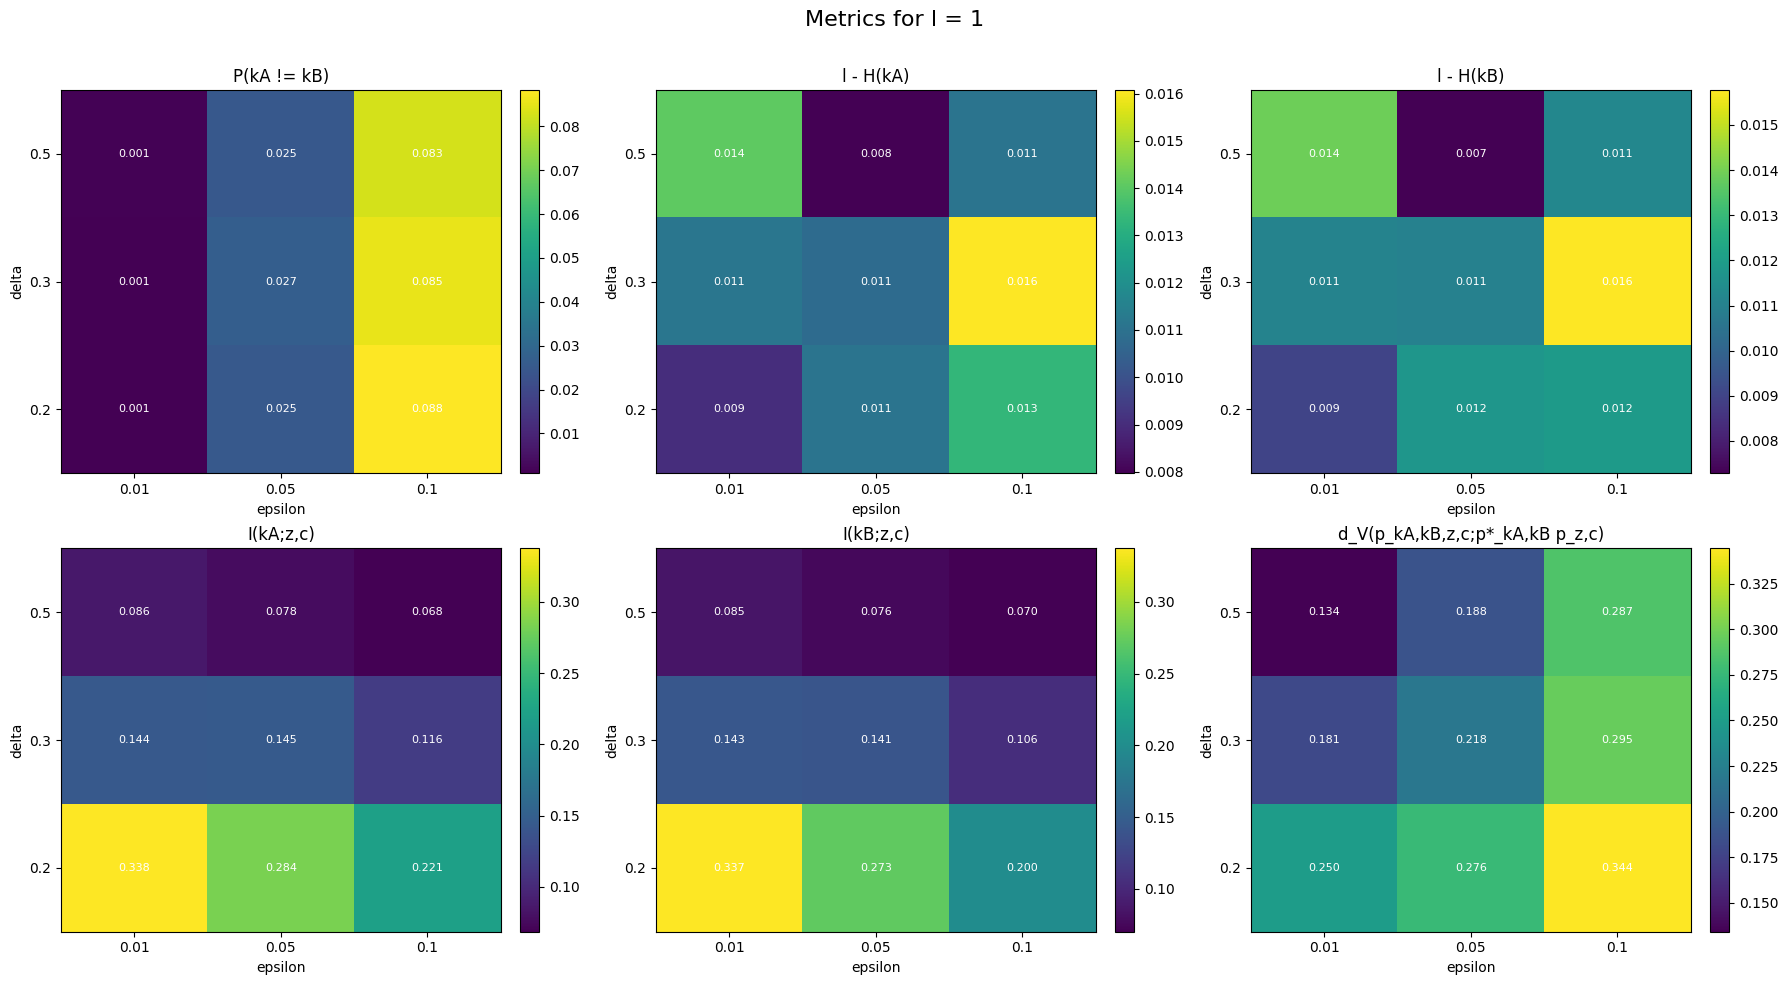

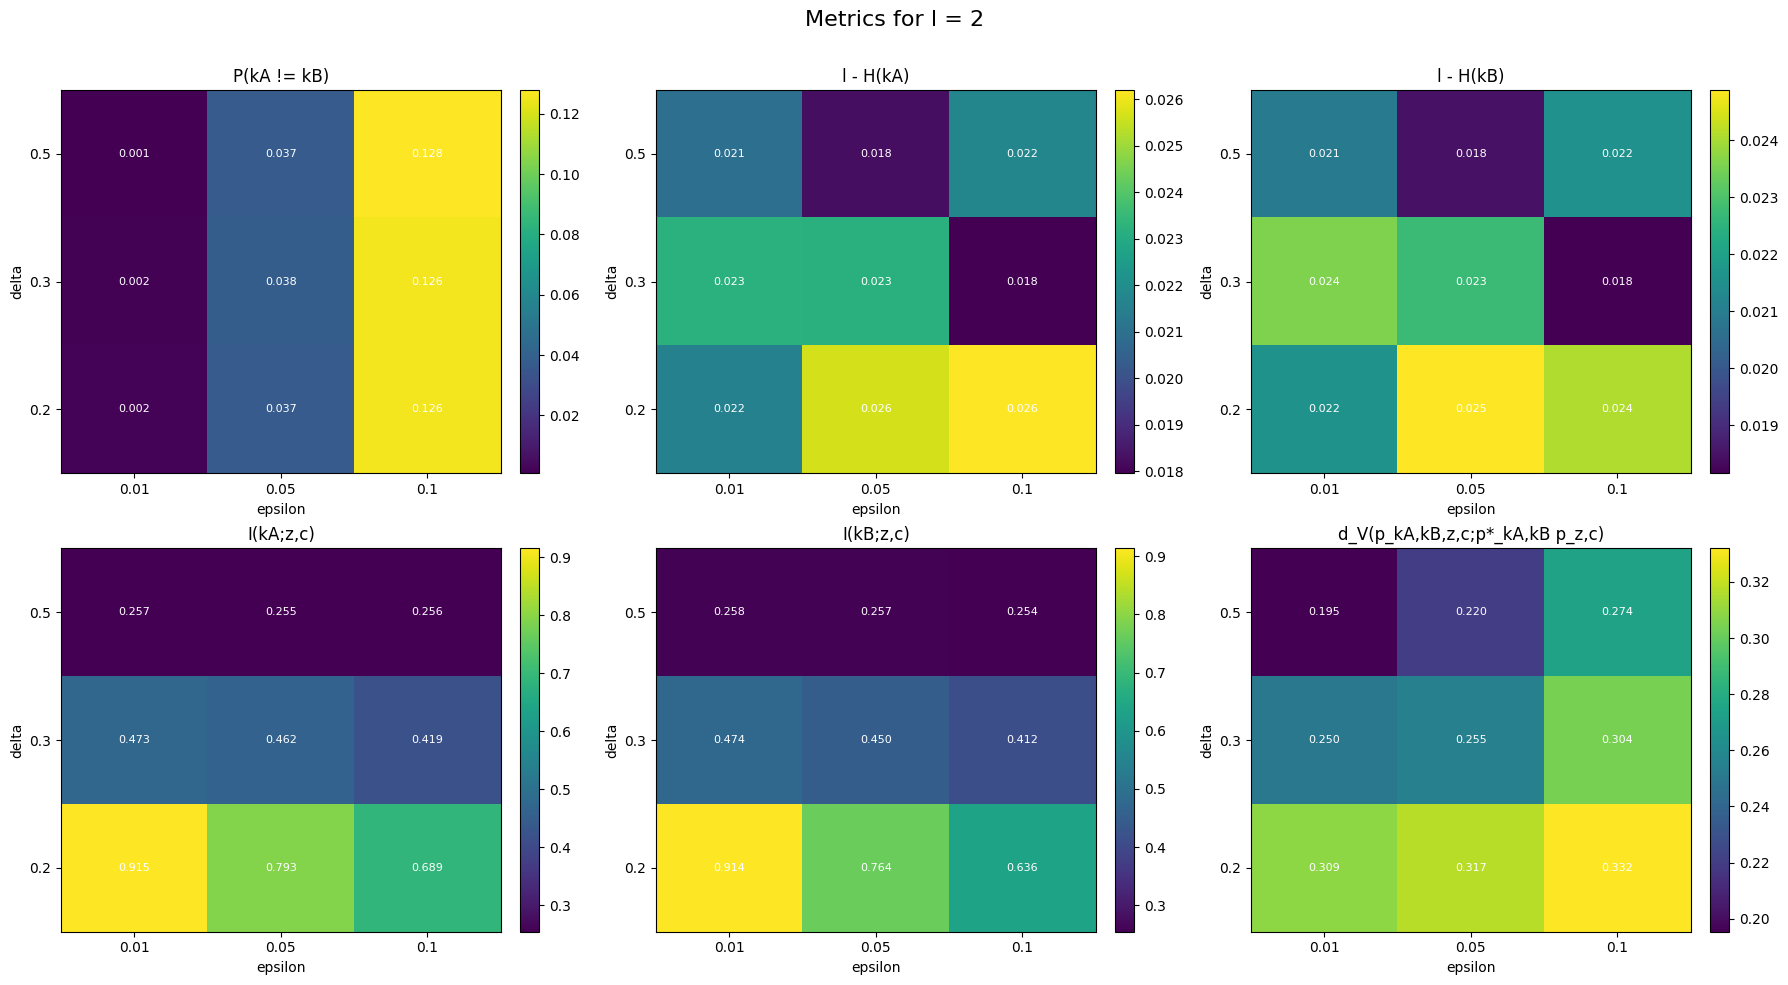

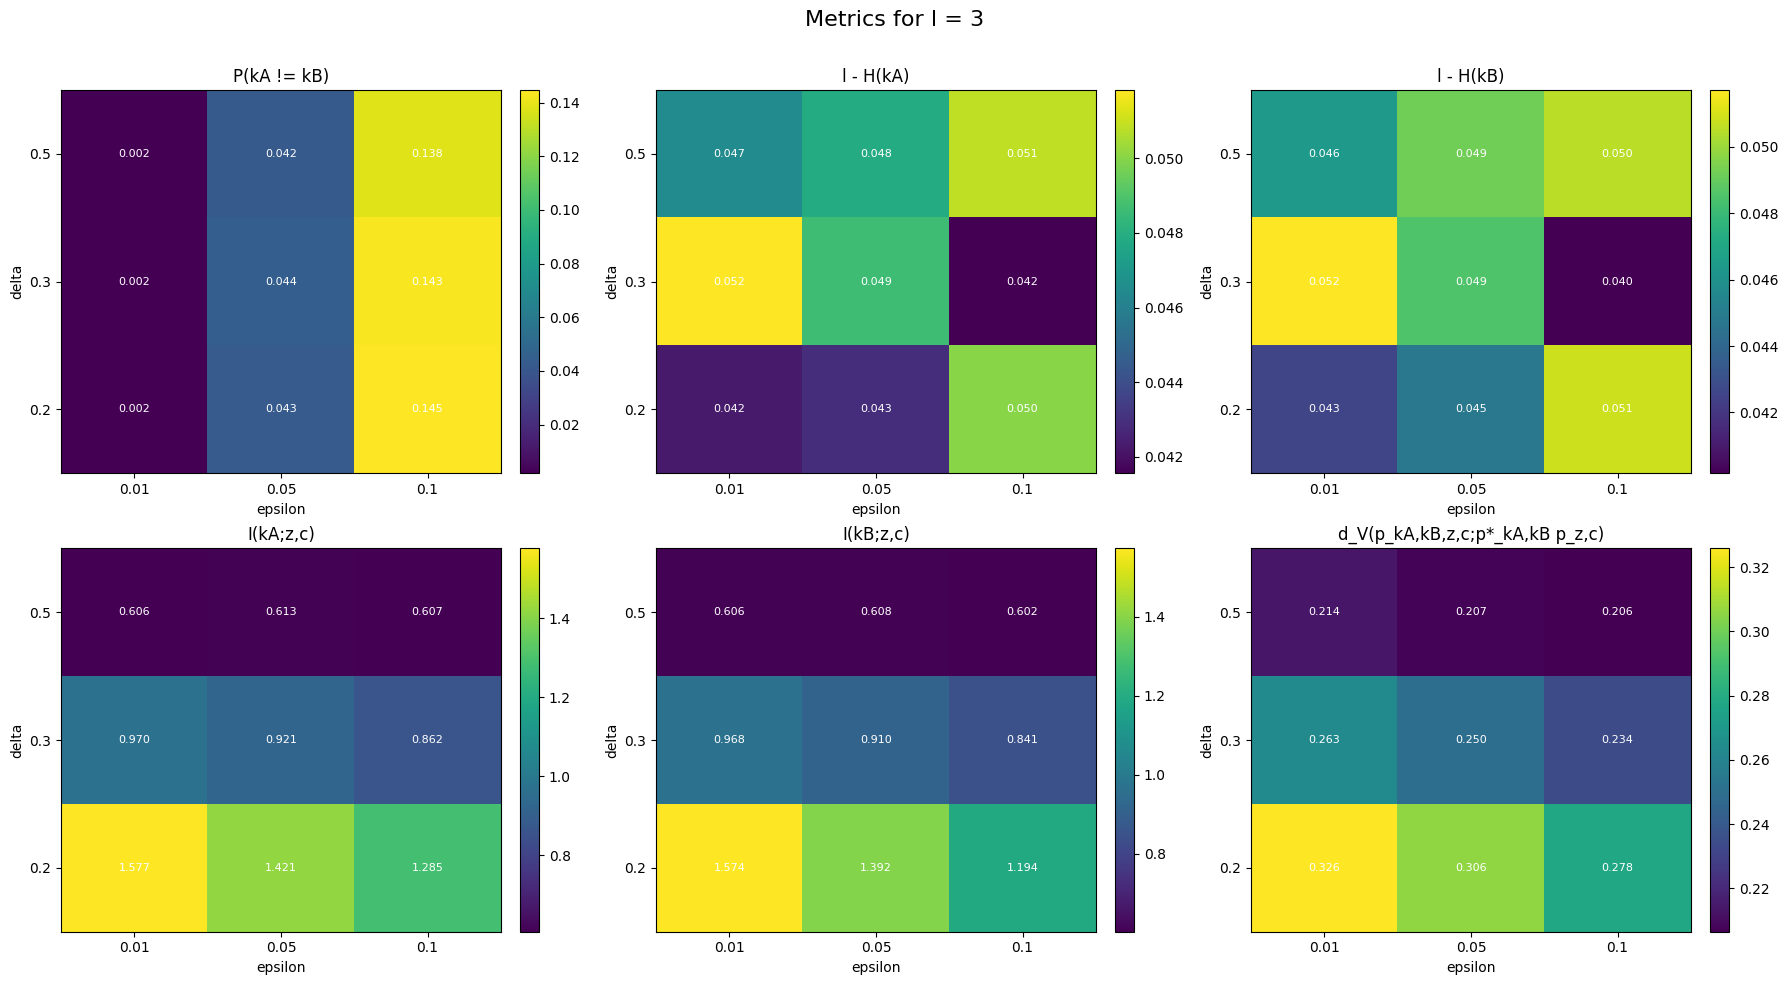

In [78]:
metrics = ['mismatch_prob', 'H_ka', 'H_kb', 'mutual_kA', 'mutual_kB', 'tvd']
titles = [
    "P(kA != kB)",
    "l - H(kA)",
    "l - H(kB)",
    "I(kA;z,c)",
    "I(kB;z,c)",
    "d_V(p_kA,kB,z,c;p*_kA,kB p_z,c)"
]
for i in range(1, 4):
    l_fissato = i 

    epsilons = sorted({k[1] for k in data.keys() if k[0] == l_fissato})
    deltas = sorted({k[2] for k in data.keys() if k[0] == l_fissato}, reverse=True)

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    for idx, metric in enumerate(metrics):
        # Costruisci la matrice dei valori
        matrix = np.zeros((len(deltas), len(epsilons)))
        for i, delta_val in enumerate(deltas):
            for j, epsilon_val in enumerate(epsilons):
                matrix[i, j] = data[(l_fissato, epsilon_val, delta_val)][metric]
                if metric == 'H_ka' or metric == 'H_kb':
                    matrix[i, j] = l_fissato - matrix[i, j]
        ax = axs[idx // 3, idx % 3]
        im = ax.imshow(matrix, aspect='auto', cmap='viridis', origin='upper')
        ax.set_xticks(np.arange(len(epsilons)))
        ax.set_yticks(np.arange(len(deltas)))
        ax.set_xticklabels(epsilons)
        ax.set_yticklabels(deltas)
        ax.set_xlabel("epsilon")
        ax.set_ylabel("delta")
        ax.set_title(titles[idx])
        # Annotazioni sui valori
        for i in range(len(deltas)):
            for j in range(len(epsilons)):
                ax.text(j, i, f"{matrix[i, j]:.3f}", ha="center", va="center", color="w", fontsize=8)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f"Metrics for l = {l_fissato}", fontsize=16)
    plt.show()